In [1]:
import torch as np
from torchvision.utils import save_image
from torch.utils import data

from tools.celeba import CelebALoader
from dataset import Split

from models3.CSA import CSA
from tools.toml import load_option
from tools.mask import mask_iter

## 数据载入

In [2]:
header_opt = load_option('options/header.toml')
loader = CelebALoader(header_opt.data_root)
dataset = Split(loader, header_opt.fine_size)
train_data = dataset.train('bbox', pil_transform=True, alpha=0.5)
trainset = data.DataLoader(train_data,
                           batch_size=header_opt.batch_size,
                           shuffle=True)
maskset = mask_iter(header_opt.mask_root, header_opt.fine_size)
print('训练集数量：', len(trainset))
print('掩码数量：', len(maskset))

训练集数量： 162770
掩码数量： 12000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


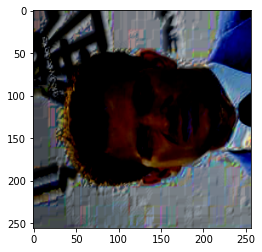

In [3]:
train_data = dataset.train('bbox', pil_transform=True, alpha=0.75)
x = train_data[14][0].transpose(0, 2)

from matplotlib import pyplot as plt
# 查看处理后的图片
plt.imshow(x);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


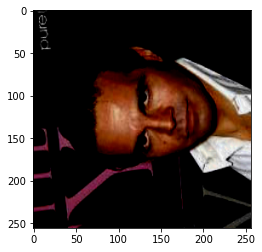

In [4]:
train_data = dataset.train('bbox', pil_transform=True, alpha=0.95)
x = train_data[7][0].transpose(0, 2)

from matplotlib import pyplot as plt
# 查看处理后的图片
plt.imshow(x);

## 模型载入

In [5]:
base_opt = load_option('options/base.toml')
opt = load_option('options/train-relief.toml')
opt.update(base_opt)
opt.update({'relief_beta': 1}) # 禁用 浮雕网络
model = CSA(**opt)

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
---------- Networks initialized -------------
UnetGeneratorCSA(
  (model): UnetSkipConnectionBlock_3(
    (model): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): UnetSkipConnectionBlock_3(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), dilation=(2, 2))
          (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (3): LeakyReLU(negative_slope=0.2, inplace=True)
          (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (6): UnetSkipConnectionBlock_3(
            (model): Sequential(
              (0): LeakyReLU(negat

## 模型训练

In [6]:
import time
from random import randint


def mask_op(mask):
    mask = mask.cuda()
    mask = mask[0][0]
    mask = np.unsqueeze(mask, 0)
    mask = np.unsqueeze(mask, 1)
    mask = mask.byte()
    return mask

In [7]:
# 超参数设定
epochs = 15
display_freq = 1000
save_epoch_freq = 1

image_save_dir = model.save_dir / 'images'
load_epoch = None
load_alpha = 0.42

In [8]:
if not image_save_dir.exists():
    image_save_dir.mkdir(parents=True, exist_ok=True)

total_steps = 0
iter_start_time = time.time()
# 载入已经训练的模型

if load_epoch:
    model.load(f"{load_epoch}-{load_alpha}")
    start_epoch = load_epoch + 1
else:
    start_epoch = 0

In [9]:
for epoch in range(start_epoch, epochs):
    epoch_start_time = time.time()
    epoch_iter = 0
    alpha = 1 # randint(0, 100)/100 if epoch < epochs-1 else 1
    train_data = dataset.train('bbox', pil_transform=True, alpha=alpha)
    trainset = data.DataLoader(train_data,
                               batch_size=model.batch_size,
                               shuffle=True)
    for batch, mask in zip(trainset, maskset):
        image = batch[0]
        mask = mask_op(mask)
        total_steps += model.batch_size
        epoch_iter += model.batch_size
        break
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


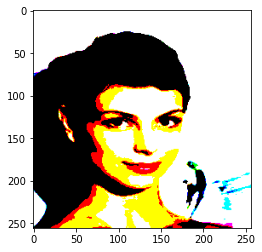

In [10]:
from matplotlib import pyplot as plt

def to_image(X):
    img = X.detach().numpy().transpose(1, 2, 0)
    return (img * 255)#.astype('uint8')

x = image
# 查看处理后的图片
img = to_image(x[0])
plt.imshow(img);

In [11]:
import torch
import torch.nn.functional as F
from torch import nn


class ReliefCNN(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.h_conv = nn.Conv2d(in_units, units, (1, 3), padding=(0, 1))
        self.v_conv = nn.Conv2d(units, units,
                                kernel_size=(3, 1), padding=(1, 0))
        self.s_conv = nn.Conv2d(units, units,
                                kernel_size=(3, 3), padding=(1, 1))

    def forward(self, X):
        x = self.h_conv(X)
        y = self.v_conv(X)
        z = torch.exp(x) + torch.exp(y) + self.v_conv(x) + self.h_conv(y)
        x = self.s_conv(x)
        return F.relu(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


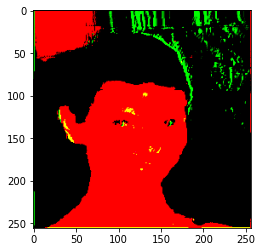

In [12]:
net = ReliefCNN(3, 3)
y = net(image)
img = to_image(y[0])
plt.imshow(img);

In [ ]:
for epoch in range(start_epoch, epochs):
    epoch_start_time = time.time()
    epoch_iter = 0
    alpha = 1 # randint(0, 100)/100 if epoch < epochs-1 else 1
    train_data = dataset.train('bbox', pil_transform=True, alpha=alpha)
    trainset = data.DataLoader(train_data,
                               batch_size=model.batch_size,
                               shuffle=True)
    for batch, mask in zip(trainset, maskset):
        image = batch[0]
        mask = mask_op(mask)
        total_steps += model.batch_size
        epoch_iter += model.batch_size
        # it not only sets the input data with mask, but also sets the latent mask.
        model.set_input(image, mask)
        model.set_gt_latent()
        model.optimize_parameters()
        if total_steps % display_freq == 0:
            real_A, real_B, fake_B = model.get_current_visuals()
            # real_A=input, real_B=ground truth fake_b=output
            pic = (np.cat([real_A, real_B, fake_B], dim=0) + 1) / 2.0
            image_name = f"epoch{epoch}-{total_steps}-{alpha}.jpg"

            save_image(pic, image_save_dir/image_name, nrow=1)
        if total_steps % 100 == 0:
            errors = model.get_current_errors()
            t = (time.time() - iter_start_time) / model.batch_size
            print(
                f"Epoch/total_steps/alpha: {epoch}/{total_steps}/{alpha}", dict(errors))
    if epoch % save_epoch_freq == 0:
        print(f'保存模型 Epoch {epoch}, iters {total_steps} 在 {model.save_dir}')
        model.save(f'{epoch}-{alpha}')
    print(
        f'Epoch/Epochs {epoch}/{epochs-1} 花费时间：{time.time() - epoch_start_time}s')
    model.update_learning_rate()

Epoch/total_steps/alpha: 0/100/1 {'G_GAN': 5.397112846374512, 'G_L1': 37.06256103515625, 'D': 0.9162887930870056, 'F': 0.08270291239023209}
Epoch/total_steps/alpha: 0/200/1 {'G_GAN': 7.107292175292969, 'G_L1': 26.254745483398438, 'D': 0.4127193093299866, 'F': 0.05251603573560715}
Epoch/total_steps/alpha: 0/300/1 {'G_GAN': 7.135892391204834, 'G_L1': 34.816349029541016, 'D': 0.7301871180534363, 'F': 0.055283188819885254}
